In [2]:
cd ../src

/home/3005019/ebm_proteins/src


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import numpy as np
import pandas as pd
from copy import copy
from tqdm.notebook import tqdm

import torch

from utils import data_utils as du
from modeling.mlp import encoding

2020-09-13 11:02:36,190 - matplotlib.pyplot - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [5]:
mic = pd.read_excel("data/sd01.xlsx")

In [6]:
# mic = mic_1.append(mic).reset_index(drop=True)

In [7]:
mic = mic[["Residue", "Wt_AA", "Mutant_AA", "Mutation", "MIC_Score"]]

In [8]:
# mic_1 = mic_1[["Residue", "Wt_AA", "Mutant_AA", "Mutation", "MIC_Score"]]

In [9]:
mic.head()

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score
0,24,H,L,H24L,-0.500000
1,24,H,P,H24P,-3.321928
2,24,H,Q,H24Q,-1.000000
3,24,H,R,H24R,-0.250000
4,24,H,Y,H24Y,-1.000000


In [10]:
len(mic)

990

# Position specific but independent contributions of each residue

In [11]:
wild_type = "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"

In [12]:
escherichia_coli = "---AEDQLGA---RVGYIELDLNSGKIL-----E--------SFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIEKHL-------TDGMTVRELCSAAITM-------------------------------------SDNTAANLLTT-IGGPKETAFLHNMGDHVTRL-DRWEPELNEAIPNDERDTTMP------------------------AAMATTLRKLL-T----GELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGA-------GGSRGIIAALGPDGSRIVVIYTTGSQ--ATMDERNRQIAEI--"

In [13]:
mic.Residue -= 1

2020-09-13 11:02:36,450 - numexpr.utils - INFO - Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2020-09-13 11:02:36,451 - numexpr.utils - INFO - Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-09-13 11:02:36,451 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [14]:
mic.head()

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score
0,23,H,L,H24L,-0.500000
1,23,H,P,H24P,-3.321928
2,23,H,Q,H24Q,-1.000000
3,23,H,R,H24R,-0.250000
4,23,H,Y,H24Y,-1.000000


In [15]:
wild_type

'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'

In [16]:
escherichia_coli

'---AEDQLGA---RVGYIELDLNSGKIL-----E--------SFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIEKHL-------TDGMTVRELCSAAITM-------------------------------------SDNTAANLLTT-IGGPKETAFLHNMGDHVTRL-DRWEPELNEAIPNDERDTTMP------------------------AAMATTLRKLL-T----GELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGA-------GGSRGIIAALGPDGSRIVVIYTTGSQ--ATMDERNRQIAEI--'

In [17]:
line1="msiqhfrvalipffaafclpvfahpetlvkvkd---AEDQLGA---RVGYIELDLNSGKIL-----E--------SFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIhysqndlveyspvtEKHL-------TDGMTVRELCSAAITM-------------------------------------SDNTAANlLL"                            
line2="TT-IGGPKElTAFLHNMGDHVTRL-DRWEPELNEAIPNDERDTTMP------------------------AAMATTLRKLL-T----GELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGA-------GerGSRGIIAALGPDGkpSRIVVIYTTGSQ--ATMDERNRQIAEI--gaslikhw" 
align=line1+line2

mapping = {}
                                                                                                                                                                                                                                            
align_pos = -1                                                                                                                                                                                                                           
nat_pos = -1                                                                                                                                                                                                                              
for c in align:                                                                                                                                                                                                                             
    if c.islower():                                                                                                                                                                                                                         
        nat_pos += 1
    if c=='-':                                                                                                                                                                                                                              
        align_pos += 1
    if c.isupper():                                                                                                                                                                                                                         
        nat_pos += 1                                                                                                                                                                                                                        
        align_pos += 1
        mapping[nat_pos] = align_pos                                                                                                                                                                             
                                                                                                                                                                                                                                            
print("positions in alignment: {}; positions in natural sequence: {}".format(align_pos, nat_pos))

positions in alignment: 329; positions in natural sequence: 285


In [18]:
mapping

{33: 3,
 34: 4,
 35: 5,
 36: 6,
 37: 7,
 38: 8,
 39: 9,
 40: 13,
 41: 14,
 42: 15,
 43: 16,
 44: 17,
 45: 18,
 46: 19,
 47: 20,
 48: 21,
 49: 22,
 50: 23,
 51: 24,
 52: 25,
 53: 26,
 54: 27,
 55: 33,
 56: 42,
 57: 43,
 58: 44,
 59: 45,
 60: 46,
 61: 47,
 62: 48,
 63: 49,
 64: 50,
 65: 51,
 66: 52,
 67: 53,
 68: 54,
 69: 55,
 70: 56,
 71: 57,
 72: 58,
 73: 59,
 74: 60,
 75: 61,
 76: 62,
 77: 63,
 78: 64,
 79: 65,
 80: 66,
 81: 67,
 82: 68,
 83: 69,
 84: 70,
 85: 71,
 86: 72,
 87: 73,
 88: 74,
 89: 75,
 90: 76,
 91: 77,
 92: 78,
 107: 79,
 108: 80,
 109: 81,
 110: 82,
 111: 90,
 112: 91,
 113: 92,
 114: 93,
 115: 94,
 116: 95,
 117: 96,
 118: 97,
 119: 98,
 120: 99,
 121: 100,
 122: 101,
 123: 102,
 124: 103,
 125: 104,
 126: 105,
 127: 143,
 128: 144,
 129: 145,
 130: 146,
 131: 147,
 132: 148,
 133: 149,
 135: 150,
 136: 151,
 137: 152,
 138: 153,
 139: 155,
 140: 156,
 141: 157,
 142: 158,
 143: 159,
 144: 160,
 146: 161,
 147: 162,
 148: 163,
 149: 164,
 150: 165,
 151: 166,
 152: 16

In [19]:
for key in mapping.keys():
    print (wild_type[key], escherichia_coli[mapping[key]])

A A
E E
D D
Q Q
L L
G G
A A
R R
V V
G G
Y Y
I I
E E
L L
D D
L L
N N
S S
G G
K K
I I
L L
E E
S S
F F
R R
P P
E E
E E
R R
F F
P P
M M
M M
S S
T T
F F
K K
V V
L L
L L
C C
G G
A A
V V
L L
S S
R R
V V
D D
A A
G G
Q Q
E E
Q Q
L L
G G
R R
R R
I I
E E
K K
H H
L L
T T
D D
G G
M M
T T
V V
R R
E E
L L
C C
S S
A A
A A
I I
T T
M M
S S
D D
N N
T T
A A
A A
N N
L L
L L
T T
T T
I I
G G
G G
P P
K K
E E
T T
A A
F F
L L
H H
N N
M M
G G
D D
H H
V V
T T
R R
L L
D D
R R
W W
E E
P P
E E
L L
N N
E E
A A
I I
P P
N N
D D
E E
R R
D D
T T
T T
M M
P P
A A
A A
M M
A A
T T
T T
L L
R R
K K
L L
L L
T T
G G
E E
L L
L L
T T
L L
A A
S S
R R
Q Q
Q Q
L L
I I
D D
W W
M M
E E
A A
D D
K K
V V
A A
G G
P P
L L
L L
R R
S S
A A
L L
P P
A A
G G
W W
F F
I I
A A
D D
K K
S S
G G
A A
G G
G G
S S
R R
G G
I I
I I
A A
A A
L L
G G
P P
D D
G G
S S
R R
I I
V V
V V
I I
Y Y
T T
T T
G G
S S
Q Q
A A
T T
M M
D D
E E
R R
N N
R R
Q Q
I I
A A
E E
I I


In [20]:
mic

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score
0,23,H,L,H24L,-0.500000
1,23,H,P,H24P,-3.321928
2,23,H,Q,H24Q,-1.000000
3,23,H,R,H24R,-0.250000
4,23,H,Y,H24Y,-1.000000
...,...,...,...,...,...
985,284,H,Q,H285Q,-0.333333
986,284,H,Y,H285Y,0.000000
987,285,W,C,W286C,-5.321928
988,285,W,L,W286L,-2.321928


In [21]:
mic["aligned_pos"] = 0

In [22]:
for i in mic.Residue:
    try:
        mic.aligned_pos[i] = mapping[mic.Residue[i]]
    except KeyError:
        continue

/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# mic_1["aligned_pos"] = 0

# mic_1.Residue -= 1

# for i in mic_1.Residue:
#     try:
#         mic_1.aligned_pos[i] = mapping[mic_1.Residue[i]]
#     except KeyError:
#         continue

In [24]:
mic

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos
0,23,H,L,H24L,-0.500000,0
1,23,H,P,H24P,-3.321928,0
2,23,H,Q,H24Q,-1.000000,0
3,23,H,R,H24R,-0.250000,0
4,23,H,Y,H24Y,-1.000000,0
...,...,...,...,...,...,...
985,284,H,Q,H285Q,-0.333333,0
986,284,H,Y,H285Y,0.000000,0
987,285,W,C,W286C,-5.321928,0
988,285,W,L,W286L,-2.321928,0


In [25]:
mic_filtered = mic.query("aligned_pos != 0")

In [26]:
# mic_1_filtered = mic_1.query("aligned_pos != 0")

In [27]:
mic_filtered

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos
42,33,A,D,A34D,-5.321928,3
43,33,A,G,A34G,-1.000000,3
44,33,A,P,A34P,-4.821928,3
45,33,A,T,A34T,-1.064386,3
46,33,A,V,A34V,0.000000,3
...,...,...,...,...,...,...
276,91,R,S,R92S,-1.000000,77
277,92,I,K,I93K,-2.821928,78
278,92,I,L,I93L,0.000000,78
279,92,I,M,I93M,0.000000,78


In [28]:
cfg = du.read_yaml("../config/config.yaml")

In [29]:
model = torch.load(cfg["output_model"])

In [30]:
model(encoding(escherichia_coli))

tensor([-0.6855], grad_fn=<AddBackward0>)

In [31]:
cfg["output_model"]

'models/contrastive_divergence.pickle'

# Correlation between MIC scores and energy differences

In [32]:
# mic_filtered = mic_1_filtered.append(mic_filtered).reset_index(drop=True)

In [33]:
mic_filtered["predicted_MIC"] = 0

/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
mic_filtered.reset_index(inplace=True, drop=True)

In [35]:
mic_filtered

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos,predicted_MIC
0,33,A,D,A34D,-5.321928,3,0
1,33,A,G,A34G,-1.000000,3,0
2,33,A,P,A34P,-4.821928,3,0
3,33,A,T,A34T,-1.064386,3,0
4,33,A,V,A34V,0.000000,3,0
...,...,...,...,...,...,...,...
234,91,R,S,R92S,-1.000000,77,0
235,92,I,K,I93K,-2.821928,78,0
236,92,I,L,I93L,0.000000,78,0
237,92,I,M,I93M,0.000000,78,0


In [36]:
old_E = model(encoding(escherichia_coli))

for i in tqdm(range(len(mic_filtered))):
    residue = mic_filtered.loc[i, "aligned_pos"]
    mutant_aa = mic_filtered.loc[i, "Mutant_AA"]

    # Mutate sequence
    new_seq = copy(escherichia_coli)
    new_seq = list(new_seq)
    new_seq[residue] = mutant_aa
    new_seq = "".join(new_seq)
    
    # Calculate energy of original and mutated sequences
    encoded_new = encoding(new_seq)
    new_E = model(encoded_new)
    
    predicted_MIC = float(new_E) - float(old_E)
    
    mic_filtered.loc[i, "predicted_MIC"] = predicted_MIC

/home/3005019/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [37]:
mic_filtered

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos,predicted_MIC
0,33,A,D,A34D,-5.321928,3,-0.006542
1,33,A,G,A34G,-1.000000,3,0.002583
2,33,A,P,A34P,-4.821928,3,0.006000
3,33,A,T,A34T,-1.064386,3,-0.011812
4,33,A,V,A34V,0.000000,3,0.002220
...,...,...,...,...,...,...,...
234,91,R,S,R92S,-1.000000,77,0.003561
235,92,I,K,I93K,-2.821928,78,0.004078
236,92,I,L,I93L,0.000000,78,0.004131
237,92,I,M,I93M,0.000000,78,0.006441


In [38]:
def rank_corr(x, y, data):
    for col in [x, y]:
        data.sort_values(col, ascending=False, inplace=True)
        data[f"{col}_rank"] = [i for i in range(len(data))]
        data[f"{col}_rank"] += 1
    
    data["d"] = data.eval(f"{x}_rank - {y}_rank")
    data["d_squared"] = data.d ** 2
    
    sum_d_squared = data.d_squared.sum()
    n = len(data)
    n_cube = n ** 3
    
    r = 1 - ((6 * sum_d_squared) / (n_cube - n))
    
    return r

In [39]:
r = rank_corr("MIC_Score", "predicted_MIC", mic_filtered)

/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [40]:
r

-0.26197918497943107

In [41]:
rank_corr("MIC_Score", "predicted_MIC", mic_filtered)

/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

-0.24978464189022898

In [42]:
r = -0.26197918497943107
n = len(mic_filtered)
df = n - 2

In [43]:
df

237

# t-Test

## Value of the t statistic (calculated from https://ruscio.pages.tcnj.edu/files/2016/08/Ruscio-2008-JMASM-CIs-for-Spearmans-Rho.pdf)

In [44]:
import math

In [45]:
t = -0.26197918497943107 / (math.sqrt((1 - (-0.26197918497943107 ** 2))/ df))

In [46]:
t

-3.901455431443154

## Confidence Intervals

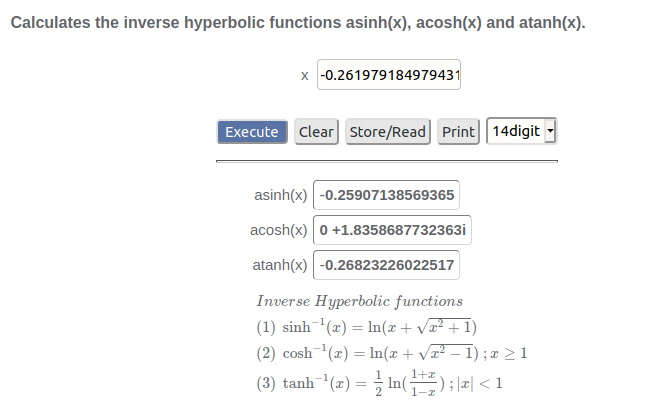

In [47]:
z_r = 0.5 * math.log((1+r)/(1-r))

In [48]:
z_r

-0.26823226022516766

UPPER BOUND

In [49]:
z_r + 1.970024 * math.sqrt((1+(r**2)/2)/(n-3))

-0.13781284404460079

LOWER BOUND

In [50]:
z_r - 1.970024 * math.sqrt((1+(r**2)/2)/(n-3))

-0.3986516764057345

# Permutate data and check correlation

In [49]:
mic_filtered.sample(frac=1)

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos,predicted_MIC,MIC_Score_rank,predicted_MIC_rank,d,d_squared
29,40,R,Q,R41Q,0.000000,13,0.000097,73,145,-72,5184
127,65,M,I,M66I,0.000000,51,0.002160,57,117,-60,3600
6,34,E,G,E35G,-1.000000,4,-0.009031,137,225,-88,7744
201,83,A,T,A84T,0.000000,69,-0.003132,32,185,-153,23409
50,45,E,V,E46V,-0.333333,18,-0.002853,98,183,-85,7225
...,...,...,...,...,...,...,...,...,...,...,...
133,66,M,I,M67I,-0.666667,52,0.006755,116,61,55,3025
70,50,S,N,S51N,-0.142857,23,0.001651,91,126,-35,1225
128,65,M,K,M66K,-5.321928,51,0.003840,223,96,127,16129
148,69,F,S,F70S,0.000000,55,-0.005250,52,205,-153,23409


In [50]:
mic_filtered.iloc[:, :7]

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos,predicted_MIC
203,84,G,E,G85E,-0.333333,70,0.018800
162,73,L,P,L74P,-5.321928,59,0.017058
217,88,L,F,L89F,-1.330482,74,0.016267
138,67,S,C,S68C,-5.321928,53,0.015802
219,88,L,I,L89I,-1.000000,74,0.015566
...,...,...,...,...,...,...,...
3,33,A,T,A34T,-1.064386,3,-0.011812
210,86,E,A,E87A,-1.000000,72,-0.012035
198,83,A,D,A84D,0.000000,69,-0.012570
223,89,G,D,G90D,0.333333,75,-0.014393


In [51]:
mic_filtered.sort_index()

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos,predicted_MIC,MIC_Score_rank,predicted_MIC_rank,d,d_squared
0,33,A,D,A34D,-5.321928,3,-0.006542,239,217,22,484
1,33,A,G,A34G,-1.000000,3,0.002583,143,113,30,900
2,33,A,P,A34P,-4.821928,3,0.006000,209,73,136,18496
3,33,A,T,A34T,-1.064386,3,-0.011812,147,235,-88,7744
4,33,A,V,A34V,0.000000,3,0.002220,76,116,-40,1600
...,...,...,...,...,...,...,...,...,...,...,...
234,91,R,S,R92S,-1.000000,77,0.003561,134,99,35,1225
235,92,I,K,I93K,-2.821928,78,0.004078,185,93,92,8464
236,92,I,L,I93L,0.000000,78,0.004131,68,91,-23,529
237,92,I,M,I93M,0.000000,78,0.006441,81,68,13,169


In [52]:
mic_filtered.sort_index().query("abs(MIC_Score_rank - predicted_MIC_rank) < 50")

,Residue,Wt_AA,Mutant_AA,Mutation,MIC_Score,aligned_pos,predicted_MIC,MIC_Score_rank,predicted_MIC_rank,d,d_squared
0,33,A,D,A34D,-5.321928,3,-0.006542,239,217,22,484
1,33,A,G,A34G,-1.000000,3,0.002583,143,113,30,900
4,33,A,V,A34V,0.000000,3,0.002220,76,116,-40,1600
5,34,E,D,E35D,-2.160964,4,-0.001561,163,169,-6,36
8,34,E,V,E35V,-2.321928,4,-0.005803,172,209,-37,1369
...,...,...,...,...,...,...,...,...,...,...,...
227,90,R,H,R91H,0.000000,76,0.009342,58,33,25,625
232,91,R,H,R92H,-0.428571,77,0.005864,102,76,26,676
234,91,R,S,R92S,-1.000000,77,0.003561,134,99,35,1225
236,92,I,L,I93L,0.000000,78,0.004131,68,91,-23,529


In [51]:
correlations = []

for _ in tqdm(range(10_000)):
    df = mic_filtered.sample(frac=1)
    df = df.iloc[:, :7]
    df = df.reset_index(drop=True)
    correlation = rank_corr("MIC_Score", "predicted_MIC", df)
    correlations.append(correlation)

In [52]:
np.array(correlations)

array([-0.25078672, -0.26551897, -0.24862522, ..., -0.27618051,
       -0.27189181, -0.25509652])

In [53]:
np.histogram(np.array(correlations))

(array([  12,  106,  528, 1398, 2605, 2701, 1744,  694,  187,   25]),
 array([-0.29781917, -0.29056872, -0.28331827, -0.27606782, -0.26881738,
        -0.26156693, -0.25431648, -0.24706603, -0.23981558, -0.23256513,
        -0.22531469]))

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

2020-09-11 12:29:41,558 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
2020-09-11 12:29:41,559 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
2020-09-11 12:29:41,560 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2020-09-11 12:29:41,561 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-09-11 12:29:41,561 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
2020-09-11 12:29:41,562 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-09-11 12

2020-09-11 12:29:41,599 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'P052' (P052-Bold.otf) normal normal bold normal>) = 10.335
2020-09-11 12:29:41,599 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'URW Bookman' (URWBookman-LightItalic.otf) italic normal light normal>) = 11.24
2020-09-11 12:29:41,600 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Nimbus Sans Narrow' (NimbusSansNarrow-Bold.otf) normal normal bold condensed>) = 10.535
2020-09-11 12:29:41,601 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'P052' (P052-Roman.otf) normal normal roman normal>) = 10.145
2020-09-11 12:29:41,601 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'Nimbus Roman' (NimbusRoman-Italic.otf) italic normal roman normal>) = 11.145
2020-09-11 12:29:41,602 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'URW Gothic' (URWGothic-DemiOblique.otf) oblique normal demi normal>) = 11.24
2020-09-11 12:29:41,603 - matplotlib.font_manager - DEBUG - f

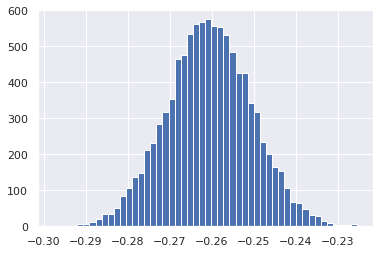

In [55]:
import matplotlib.pyplot as plt

_ = plt.hist(np.array(correlations), bins=50)

plt.show()

In [56]:
pd.Series(correlations).describe()

count    10000.000000
mean        -0.260633
std          0.010119
min         -0.297819
25%         -0.267393
50%         -0.260690
75%         -0.253794
max         -0.225315
dtype: float64

In [57]:
len(correlations)

10000

# Randomly permute data

In [51]:
mic_filtered.sort_index(inplace=True)

/home/3005019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
correlations = []

for _ in tqdm(range(1_000_000)):
    df = mic_filtered.copy()
    df['MIC_Score'] = np.random.permutation(df["MIC_Score"].values)
    correlation = rank_corr("MIC_Score", "predicted_MIC", df)
    correlations.append(correlation)

In [55]:
correlations

[0.02063570197953657,
 0.0011893041735522303,
 -0.048899476108434925,
 -0.09208888576351049,
 0.03231074856720928,
 0.03768327414647865,
 -0.011851728138954298,
 0.054370451109314044,
 0.11668541893744944,
 0.044458703983685566,
 -0.019270595267395718,
 -0.061479905769839416,
 -0.07976512780844547,
 -0.05252364544144017,
 -0.11064484371154326,
 -0.03364860588586893,
 -0.04404732604338801,
 -0.03622323406349981,
 0.041069231039696175,
 -0.04677841848036279,
 -0.008308427973700017,
 0.016644984353574088,
 0.02438293308955386,
 0.03231953869413873,
 -0.010584191835730117,
 0.06521395168946242,
 0.006360535846137605,
 0.0032637741288984445,
 0.08256654126085583,
 -0.06317903730529872,
 -0.005532505889385142,
 0.012163777644949247,
 -0.006390422277697594,
 0.10183098343940089,
 -0.0015646425934390251,
 0.056564466790900436,
 0.0028585492774515497,
 -0.03216395344748779,
 0.029247389332301976,
 0.10354945325410503,
 0.08657396012798424,
 -0.046130586125663564,
 0.12050121303751626,
 -0.06368

In [53]:
pd.Series(correlations).describe()

count    1000000.000000
mean           0.005993
std            0.064884
min           -0.291827
25%           -0.037694
50%            0.006063
75%            0.049866
max            0.299038
dtype: float64

In [72]:
pd.Series(correlations).describe()

count    1000000.000000
mean           0.006039
std            0.064868
min           -0.287181
25%           -0.037720
50%            0.006154
75%            0.049916
max            0.301057
dtype: float64

In [86]:
r

-0.26197918497943107

In [55]:
import matplotlib.pyplot as plt

In [58]:
import seaborn as sns
sns.set()

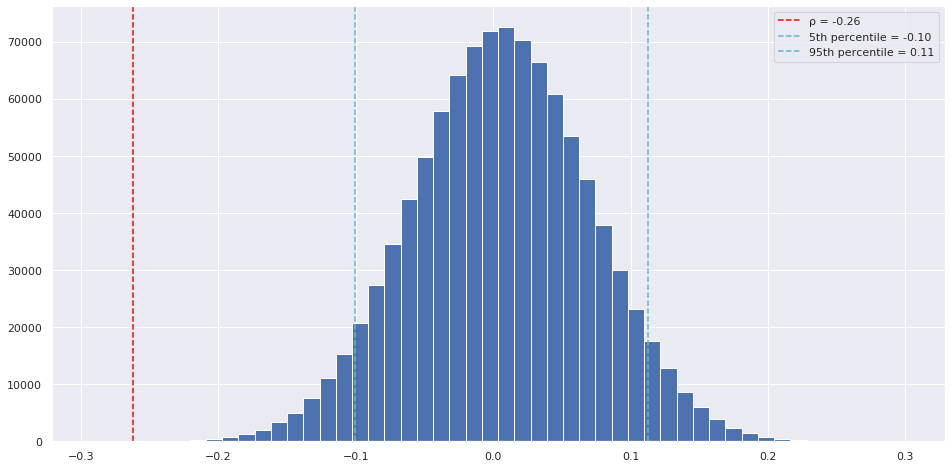

In [65]:
plt.figure(figsize=(16, 8))
a = plt.hist(correlations, bins=50)
b = plt.axvline(r, color="red", linestyle="dashed")
q_5 = plt.axvline(-0.10040966386554624, color="c", linestyle="dashed")
q_95 = plt.axvline(0.11248466122850809, color="c", linestyle="dashed")
plt.legend(["ρ = -0.26", "5th percentile = -0.10", "95th percentile = 0.11"]);

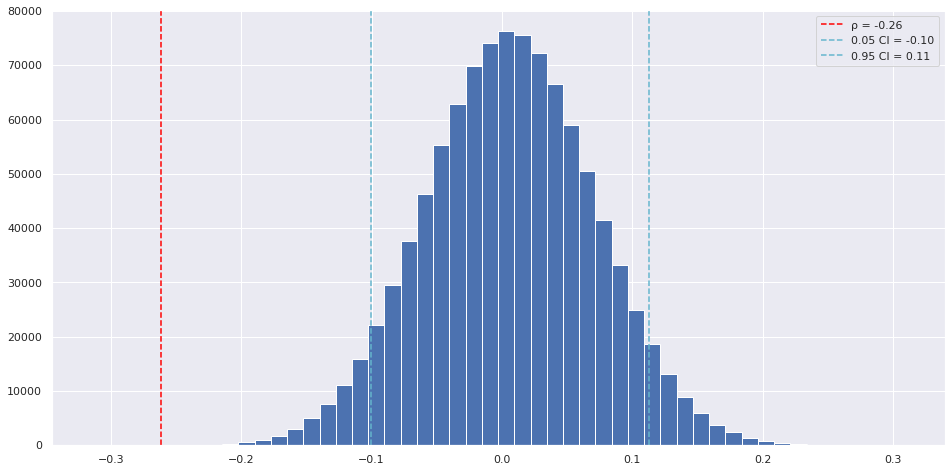

In [98]:
plt.figure(figsize=(16, 8))
a = plt.hist(correlations, bins=50)
b = plt.axvline(r, color="red", linestyle="dashed")
q_5 = plt.axvline(-0.10040966386554624, color="c", linestyle="dashed")
q_95 = plt.axvline(0.11248466122850809, color="c", linestyle="dashed")
plt.legend(["ρ = -0.26", "0.05 CI = -0.10", "0.95 CI = 0.11"]);

In [99]:
20/1000000

2e-05

In [100]:
2e-05

2e-05

In [61]:
correlations_series = pd.Series(correlations)

In [66]:
correlations_series[correlations_series < r].count()

20

In [62]:
correlations_series.quantile(q=0.05)

-0.10095548679722932

In [63]:
correlations_series.quantile(q=0.95)

0.11266925389402617